# Обучаем!
В работе американцев использовались линейные модели. Они показали себя как самые лучшие. Но не лишним будет попробовать и еще что-нибудь.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import string
from bs4 import BeautifulSoup
import copy
import unicodedata
import sys
import requests
from pymystem3 import Mystem

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

In [3]:
def top_features(importance_array, n_features, names, title='feature importance', plot=True):
    d = pd.DataFrame(data = importance_array, index = names, columns=['Importance'])
    d = d.sort_values(by = 'Importance', ascending = False)
    if plot is True:
        return d[0:n_features].plot(kind='bar', title=title)
    else:
        return d[0:n_features]

## Препроцессинг

In [4]:
#Импортируем дату (вдруг она отличается)
train = pd.read_csv('https://github.com/Chernechev/RussianFWords/raw/main/train.csv', index_col='Unnamed: 0')
test = pd.read_csv('https://github.com/Chernechev/RussianFWords/raw/main/test.csv', index_col='Unnamed: 0')

In [5]:
y_train = train['target']
y_test = test['target']
X_train = train.drop(['word', 'stem', 'detagged', 'ipa', 'target', 'sounds'], axis=1)
X_test = test.drop(['word', 'stem', 'detagged', 'ipa', 'target', 'sounds'], axis=1)

## Обучим только на тегах из Вики

In [8]:
wikitags = X_train.columns[49:103]
wikitag_train = X_train[wikitags]
wikitag_test = X_test[wikitags]

In [9]:
wikitag_train.head()

,бранн.,вульг.,высок.,гипокор.,груб.,детск.,диал.,дисфм.,жарг.,ирон.,...,унич.,усилит.,устар.,фам.,школьн.,шутл.,эвф.,экзот.,экспр.,эррат.
1723,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2096,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
65,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
wikiLog = LogisticRegression()
wikiLog.fit(wikitag_train, y_train)

LogisticRegression()

Text(0.5, 1.0, 'test score')

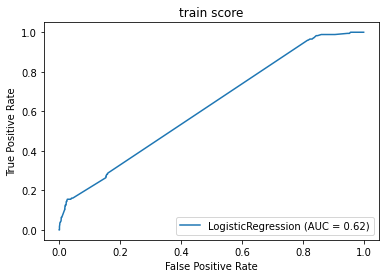

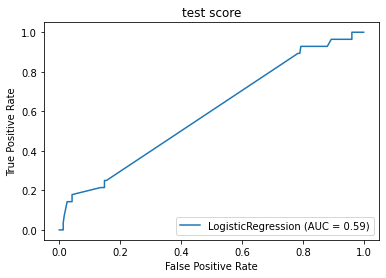

In [11]:
plot_roc_curve(wikiLog, wikitag_train, y_train)
plt.gca().set_title('train score')

plot_roc_curve(wikiLog, wikitag_test, y_test)
plt.gca().set_title('test score')

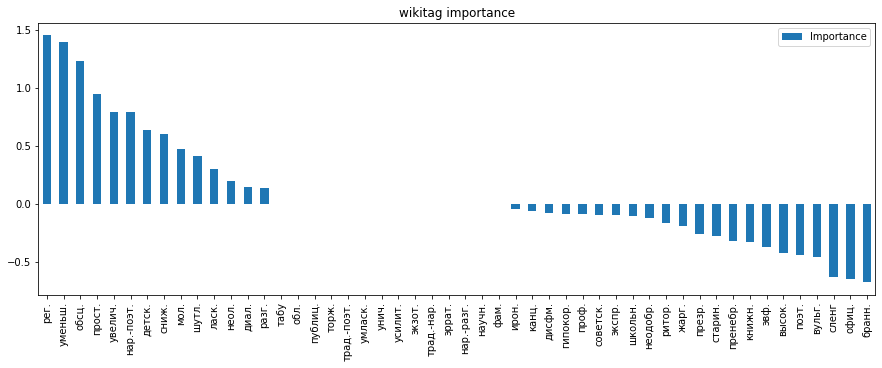

In [12]:
top_features(wikiLog.coef_.T, 50, title='wikitag importance', names=wikitags)
plt.gcf().set_size_inches((15,5))

In [32]:
train[train['бранн.'] == 1]

,word,stem_bastard,stem,detagged,length,ngramm к,ngramm у,ngramm п,ngramm а,ngramm ч,...,sign u,sign ʐ,sign ʲ,sign p,sign f,sign k,sign b,sign ɕ,target,freq
941,мымра,0,мымра_NOUN,мымра,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.548
2178,чучело,0,чучело_NOUN,чучело,6,0,1,0,0,2,...,0,0,0,0,0,0,0,2,0,3.139
1763,собака,0,собака_NOUN,собака,6,1,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0.093
671,клуша,0,клуша_NOUN,клуша,5,1,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1.020
469,жопа,0,жопа_NOUN,жопа,4,0,0,1,0,0,...,0,1,0,1,0,0,0,0,0,0.000
293,гнида,0,гнида_NOUN,гнида,5,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,11.495


In [ ]:
Есть проблема с "рег." – там есть, например, слово "море" (одно из его значений – региональное). Но ML сам с этим справится.
Другая проблема – с "нар.-поэт." и "увелич.". Там есть только одно слово, поэтому машина переобучается

#### Логистическая Регрессия

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Logistic = Pipeline([('scaler', StandardScaler()), ('est', LogisticRegression())])
Logistic.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('est', LogisticRegression())])

In [17]:
from sklearn.model_selection import learning_curve

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
def plot_learning_curve(pipe, X, y):
    
    train_sizes = np.linspace(0.01, 1, 20)
    N_train, val_train, val_test = learning_curve(pipe,
                                                  X, y, train_sizes=train_sizes, cv=5,
                                                  scoring='roc_auc')
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('Acc')
    plt.legend()

Text(0.5, 1.0, 'test score')

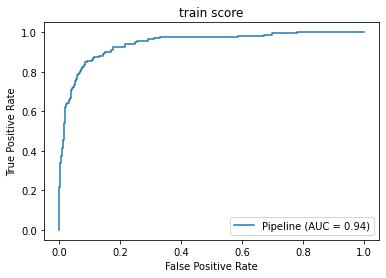

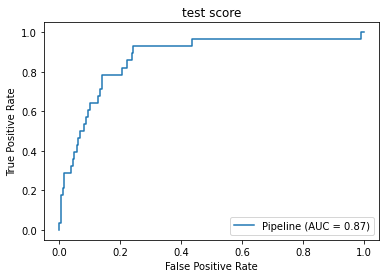

In [18]:
plot_roc_curve(Logistic, X_train, y_train)
plt.gca().set_title('train score')

plot_roc_curve(Logistic, X_test, y_test)
plt.gca().set_title('test score')

/Users/pasace/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/pasace/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/pasace/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/pasace/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1372, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/pasace/op

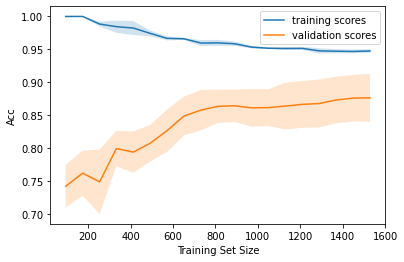

In [19]:
plot_learning_curve(Logistic, X_train, y_train)

In [20]:
def get_with_feature(feature):
    """Возвращает слова, имеющие этот признак. Только для даммис."""
    
    return X_train[X_train[feature] != 0]

#### Forest

Переобучается

In [21]:
Forest = Pipeline([('scaler', StandardScaler()), ('est', RandomForestClassifier(random_state=42))])
Forest.fit(X_train, y_train)
Forest.score(X_test,y_test)

0.9230769230769231

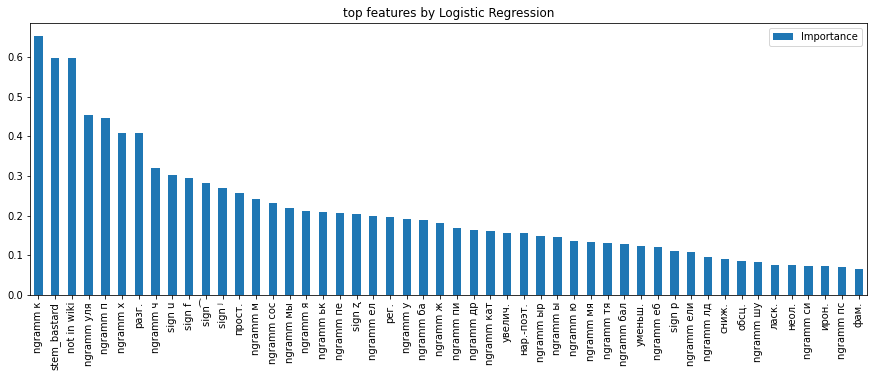

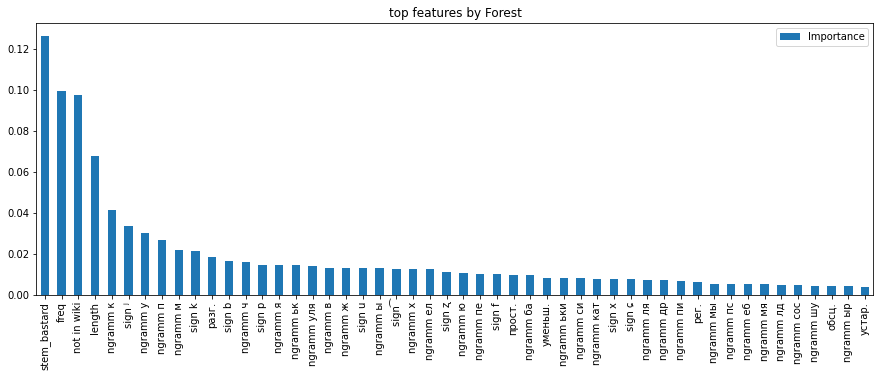

In [28]:
top_features(Logistic['est'].coef_.T, 50, title='top features by Logistic Regression', names=X_train.columns)
plt.gcf().set_size_inches((15,5))

top_features(Forest['est'].feature_importances_.T, 50, title='top features by Forest', names=X_train.columns)
plt.gcf().set_size_inches((15,5))

Text(0.5, 1.0, 'test score')

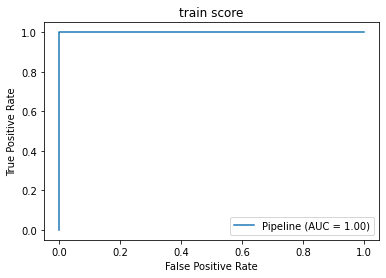

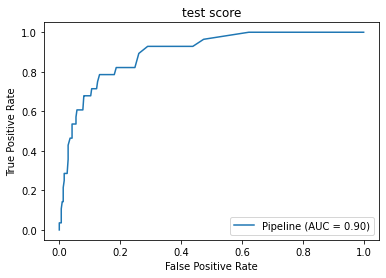

In [23]:
plot_roc_curve(Forest, X_train, y_train)
plt.gca().set_title('train score')

plot_roc_curve(Forest, X_test, y_test)
plt.gca().set_title('test score')

#### SVM

Дает улучшение качества классификации

In [24]:
from sklearn.svm import SVC
svc = Pipeline([('scaler', StandardScaler()), ('est', SVC())])
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.9378698224852071

Text(0.5, 1.0, 'test score')

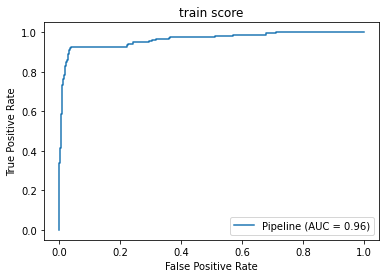

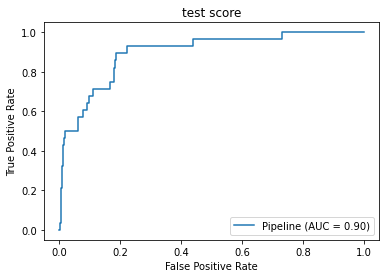

In [25]:
plot_roc_curve(svc, X_train, y_train)
plt.gca().set_title('train score')

plot_roc_curve(svc, X_test, y_test)
plt.gca().set_title('test score')

In [27]:
svc['est'].score(X_test,y_test)


0.9171597633136095